# Phishing detection via large language models

## Struktur des Notebooks

    1. Pakete installieren
    
    2. Prompt & Kontext
        -> Daten aus der CSV extrahieren
        -> Prompt und Kontext für LLM definieren
    
    3. Kommunikation mit LLM API
        -> Verwendete Large Language Models:
            > OpenAI GPT-4o API
            > Google Gemini 1.5 Pro API
            > Meta Llama 3.1 405b API
            > Antrophic Claude Sonnet 3.5 API
            
    4. Daten aus API Antwort extrahieren
        -> Klassifikation und Wahrscheinlichkeit in Variablen laden
        
    5. Analyse
        -> Berechnung der Metriken:
            > Accuracy
            > Precision
            > Recall
            > F1-Score
            > AUC-ROC
            > Confusion Matrix
            
    6. Visualisierung der Ergebnisse

## Installing Packages

In [1]:
# OpenAI GPT-4
!pip install openai pandas
import openai

# Google Gemini
!pip install -U google-generativeai
import google.generativeai as genai
import os

# Meta LLaMA
!pip install llamaapi
import json
from llamaapi import LlamaAPI

# Anthropic Claude
!pip install anthropic
import anthropic

# Analysis of results
import pandas as pd
import re
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
import numpy as np

# Visualization of results
import matplotlib.pyplot as plt
import seaborn as sns

## Context & Prompt

### Extract data from csv to dataframe

In [2]:
def load_csv_to_dataframe(csv_file_path):
    """
    Load a CSV file into a DataFrame.

    Parameters:
    csv_file_path (str): The path to the CSV file.

    Returns:
    DataFrame: The loaded DataFrame.
    """
    return pd.read_csv(csv_file_path)

In [ ]:
true_labels = [
               0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 
               0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 
               1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
               0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 
               0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 
               1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 
               0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 
               0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 
               0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 
               0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 
               0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 
               0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
               1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
               0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 
               0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
               0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 
               0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 
               0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 
               0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
               0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 
               0, 1, 0, 0, 0, 0, 0, 0, 0, 0
            ]



### Create prompt

In [4]:
def create_prompt_from_dataframe(df):
    """
    Create prompts from a DataFrame to analyze emails for phishing attempts.
    
    Parameters:
    df (DataFrame): The DataFrame containing email data.
    
    Returns:
    list: A list of prompts for each email in the DataFrame.
    """
    phishing_prompt_template = """
Please analyze the following email and determine if it is a phishing attempt.
Provide the following information in the specified format:

1. Classification: 1 for Yes (Phishing) or 0 for No (Not Phishing)
2. Probability: A value between 0 and 1 representing the probability that the email is Phishing

Then, provide your reasoning in bullet points based on the characteristics of the email.

Email:
"Sender: {sender}
Receiver: {receiver}
Subject: {subject}
Body: {body}"
"""

    prompts = []
    for _, row in df.iterrows():
        prompt = phishing_prompt_template.format(sender=row['sender'], receiver=row['receiver'], subject=row['subject'], body=row['body'])
        prompts.append(prompt)
    
    return prompts

### Create context

In [5]:
cybersec_context = "You are a cybersecurity expert specializing in identifying phishing emails. Your task is to analyze emails and distinguish between phishing emails and regular emails."

### Initialize prompt

In [8]:
# load csv-file and parse to prompt
csv_file_path = 'email_dataset.csv'
df = load_csv_to_dataframe(csv_file_path)
phishing_prompt = create_prompt_from_dataframe(df)

## OpenAI GPT-4

In [9]:
def request_gpt4_api(context, prompt):
    """
    Send a prompt to the GPT-4 API and retrieve the response.

    This function sets the OpenAI API key, initializes the OpenAI client, constructs the messages, 
    sends the prompt to the GPT-4 API, and retrieves the response content. It also handles any potential errors.

    Parameters:
    context (str): The system context to be used by the API. This can include various settings or configurations.
    prompt (str): The user prompt to be sent to the GPT-4 API.

    Returns:
    str: The content of the response message from the GPT-4 API.
    """
    # Set the OpenAI API key from the environment variable
    os.environ["OPENAI_API_KEY"] = "my_key"
    api_key = os.getenv("OPENAI_API_KEY")

    # Initialize the OpenAI Client
    client = openai.OpenAI(api_key=api_key)

    try:
        messages = [
            {"role": "system", "content": context},
            {"role": "user", "content": prompt}
        ]
        
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=messages,
            temperature=0, # Response is more deterministic
            max_tokens=500 # Response uses max 500 tokens
        )
        
        # Output the response
        response_message = response.choices[0].message.content
        
        # return the response message
        return response_message
       
    # Error handling
    except Exception as e:
        print(f"An error occurred: {e}")

## Google Gemini

In [10]:
def request_gemini_api(context, prompt):
    """
    Send a prompt to the Gemini API and retrieve the response.

    This function configures the Gemini API with the provided API key, creates a generative model with specific settings,
    starts a chat session with the provided context, sends the user prompt to the API, and retrieves the response text.

    Parameters:
    context (str): The system context to be used by the API. This can include various settings or configurations.
    prompt (str): The user prompt to be sent to the Gemini API.

    Returns:
    str: The text of the response message from the Gemini API.
    """
    genai.configure(api_key="my_key")

    # Create the model
    generation_config = {
      "temperature": 0,
      "max_output_tokens": 500,
      "response_mime_type": "text/plain",
    }

    model = genai.GenerativeModel(
      model_name="gemini-1.5-pro",
      generation_config=generation_config
    )

    # Start the chat session
    chat_session = model.start_chat(
       history=[
        {"role": "model", "parts": context}
      ]
    )

    # Send the message and get the response
    response = chat_session.send_message(prompt)

    # return the response text
    return response.text

## Meta LLaMA

In [11]:
def request_llama_api(context, prompt):
    """
    Send a prompt to the Llama API and retrieve the response.

    This function initializes the Llama API SDK, builds an API request with the specified model and parameters,
    executes the request, and retrieves the content of the response message.

    Parameters:
    context (str): The system context to be used by the API. This can include various settings or configurations.
    prompt (str): The user prompt to be sent to the Llama API.

    Returns:
    str: The content of the response message from the Llama API.
    """
    # Initialize the SDK
    llama = LlamaAPI("my_key")
  
    # Build the API request
    api_request_json = {
        "model": "llama3.1-405b",
        "messages": [
            {"role": "system", "content": context},
            {"role": "user", "content": prompt},
        ],
        "max_tokens": 500,
        "temperature": 0,
    }

    # Execute the Request
    response = llama.run(api_request_json)
    
    # Extract and print the content
    response_content = response.json()["choices"][0]["message"]["content"]
    
    # return the response text
    return response_content

## Anthropic Claude

In [12]:
def request_claude_api(context, prompt):
    """
    Send a prompt to the Claude API and retrieve the response.

    This function sets up the API key for the Anthropic API, initializes the Anthropic client,
    creates a message with the specified model and parameters, and retrieves the content of the message.

    Parameters:
    context (dict): The system context to be used by the API. This can include various settings or configurations.
    prompt (str): The user prompt to be sent to the Claude API.

    Returns:
    str: The content of the response message from the Claude API.
    """
    # Set the API key for the Anthropic API from the environment variable
    os.environ["ANTHROPIC_API_KEY"] = "my_key"
    api_key = os.environ.get("ANTHROPIC_API_KEY")
    
    # Initialize the Anthropic client
    client = anthropic.Anthropic(api_key=api_key)

    # Create a message with the specified model and parameters
    message = client.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=500,
        system=context,
        messages=[
            {"role": "user", "content": prompt}
        ]
    )
    
    # Get the content of the message
    result = message.content
    
    # return the result
    return result

## Analysis of results

### Collect responses

In [13]:
def collect_api_responses(context, prompt, api_function):
    """
    Send prompts to the API and collect responses in a DataFrame.

    Parameters:
    prompts (list): List of prompts to send to the API.
    context (dict): Context for the API.
    api_function (function): Function to call the API with context and prompt.

    Returns:
    pd.DataFrame: DataFrame containing prompts and their corresponding responses.
    """
    # Initialize an empty DataFrame with the desired columns
    df = pd.DataFrame(columns=["prompt", "response"])

    # Send the prompts to the API and store the results
    for prompt in phishing_prompt:
        response = api_function(context, prompt)
        if response:
            # Create a temporary DataFrame with the new result
            temp_df = pd.DataFrame({"prompt": [prompt], "response": [response]})
            # Add the new row to the DataFrame using pd.concat
            df = pd.concat([df, temp_df], ignore_index=True)

    return df

In [14]:
result_gpt4_api = collect_api_responses(cybersec_context, phishing_prompt, request_gpt4_api)

In [ ]:
result_gemini_api = collect_api_responses(cybersec_context, phishing_prompt, request_gemini_api)

In [67]:
result_llama_api = collect_api_responses(cybersec_context, phishing_prompt, request_llama_api)

In [68]:
result_claude_api = collect_api_responses(cybersec_context, phishing_prompt, request_claude_api)

### Extract classification & probability

In [69]:
def extract_classification_and_probability(df, input_name):
    """
    Extracts classification and probability values from a DataFrame based on the input source.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the responses.
    input_name (str): The name of the input source to determine the extraction method.

    Returns:
    tuple: Two lists containing classifications and probabilities.
    """
    classifications = []
    probabilities = []

    if 'claude' in input_name.lower():
        # Claude-specific extraction
        for index, row in df.iterrows():
            response_list = row['response']

            if isinstance(response_list, list) and len(response_list) > 0:
                text_block = response_list[0].text
                lines = text_block.split('\n')

                try:
                    # Look for lines containing "Classification" and "Probability"
                    classification_line = next(line for line in lines if 'Classification' in line)
                    probability_line = next(line for line in lines if 'Probability' in line)

                    # Use regex to extract the number after the ":"
                    classification = int(re.search(r'\d+', classification_line.split(': ')[1]).group())
                    probability = float(re.search(r'\d+\.\d+', probability_line.split(': ')[1]).group())

                except (StopIteration, IndexError, ValueError, AttributeError):
                    # Set default values if extraction fails
                    classification = None
                    probability = None

                # Add values to the lists
                classifications.append(classification)
                probabilities.append(probability)
            else:
                classifications.append(None)
                probabilities.append(None)
    else:
        # Standard extraction
        for index, row in df.iterrows():
            response = row['response']

            # Remove all "*"
            response = response.replace('*', '')

            # Split response lines
            lines = response.split('\n')

            try:
                # Look for lines containing "Classification" and "Probability"
                classification_line = next(line for line in lines if 'Classification' in line)
                probability_line = next(line for line in lines if 'Probability' in line)

                # Extract the first number after the ":"
                classification = int(classification_line.split(': ')[1].split()[0])
                probability = float(probability_line.split(': ')[1].split()[0])

            except (StopIteration, IndexError, ValueError):
                # Set default values if extraction fails
                classification = None
                probability = None

            # Add values to the lists
            classifications.append(classification)
            probabilities.append(probability)

    return classifications, probabilities

In [71]:
classifications_gpt4, probabilities_gpt4 = extract_classification_and_probability(result_gpt4_api, "gpt4")
classifications_gemini, probabilities_gemini = extract_classification_and_probability(result_gemini_api, "gemini")
classifications_llama, probabilities_llama = extract_classification_and_probability(result_llama_api, "llama")
classifications_claude, probabilities_claude = extract_classification_and_probability(result_claude_api, "claude")

### Calculate metrics

In [97]:
def calculate_metrics(classifications, probabilities, true_labels):
    """
    Calculate various binary classification metrics and AUC-ROC.

    Parameters:
    classifications (list of int): The predicted classifications (0 or 1) for each sample.
    probabilities (list of float): The predicted probabilities for each sample, representing the likelihood of being classified as 1.
    true_labels (list of int): The true labels for each sample (0 for non-phishing, 1 for phishing).

    Returns:
    dict: A dictionary containing the calculated metrics:
        - Accuracy: The ratio of correctly predicted instances.
        - Precision: The ratio of correctly predicted positive instances to all predicted positives.
        - Recall: The ratio of correctly predicted positive instances to all actual positives.
        - F1-Score: The harmonic mean of precision and recall.
        - MCC (Matthews Correlation Coefficient): A measure of the quality of binary classifications.
        - AUC-ROC: The area under the receiver operating characteristic curve.
        - Avg_Probability: The average probability of the predictions.
    """
    # Calculate binary classification metrics
    accuracy = accuracy_score(true_labels, classifications)
    precision = precision_score(true_labels, classifications, zero_division=0)
    recall = recall_score(true_labels, classifications)
    f1 = f1_score(true_labels, classifications)
    mcc = matthews_corrcoef(true_labels, classifications)
    
    # Calculate AUC-ROC
    auc_roc = roc_auc_score(true_labels, probabilities)
    
    # Calculate average probability
    avg_probability = np.mean(probabilities)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "MCC": mcc,
        "AUC-ROC": auc_roc,
        "Avg_Probability": avg_probability
    }


In [98]:
metrics_gpt4 = calculate_metrics(classifications_gpt4, probabilities_gpt4, true_labels)
metrics_gemini = calculate_metrics(classifications_gemini, probabilities_gemini, true_labels)
metrics_llama = calculate_metrics(classifications_llama, probabilities_llama, true_labels)
metrics_claude = calculate_metrics(classifications_claude, probabilities_claude, true_labels)

In [99]:
# Create a dictionary to store all metrics
all_metrics = {
    "Gpt4": metrics_gpt4,
    "Gemini": metrics_gemini,
    "Llama": metrics_llama,
    "Claude": metrics_claude
}

# Print the metrics in a formatted way
for model_name, metrics in all_metrics.items():
    print(f"Model: {model_name}")
    for metric_name, metric_value in metrics.items():
        print(f"  {metric_name}: {metric_value:.4f}")
    print()  # Blank line for better readability


Model: Gpt4
  Accuracy: 0.7895
  Precision: 0.6364
  Recall: 1.0000
  F1-Score: 0.7778
  MCC: 0.6513
  AUC-ROC: 1.0000
  Avg_Probability: 0.5237

Model: Gemini
  Accuracy: 0.8947
  Precision: 0.7778
  Recall: 1.0000
  F1-Score: 0.8750
  MCC: 0.8051
  AUC-ROC: 1.0000
  Avg_Probability: 0.4711

Model: Llama
  Accuracy: 0.8421
  Precision: 0.7000
  Recall: 1.0000
  F1-Score: 0.8235
  MCC: 0.7246
  AUC-ROC: 1.0000
  Avg_Probability: 0.4211

Model: Claude
  Accuracy: 0.9474
  Precision: 0.8750
  Recall: 1.0000
  F1-Score: 0.9333
  MCC: 0.8956
  AUC-ROC: 1.0000
  Avg_Probability: 0.4026



## Visualization of results

In [100]:
def plot_model_metrics(all_metrics):
    """
    Plots various visualizations to compare the performance of different models based on provided metrics.

    Parameters:
    all_metrics (dict): A dictionary where the keys are model names and the values are dictionaries of metrics. 
                        Each metric dictionary should contain the following keys: 'Accuracy', 'Precision', 
                        'Recall', 'F1-Score', 'MCC', 'AUC-ROC', 'Avg_Probability'.

    Visualizations:
    1. Bar Chart of Accuracy: Displays the accuracy of each model.
    2. Bar Chart of Precision, Recall, F1-Score, MCC, AUC-ROC, and Avg_Probability: Compares these metrics across models.
    3. Heatmap: Shows a heatmap of all metrics for each model.
    4. Radar Chart: Plots a radar chart to visualize the metrics of each model.
    """
    # Convert dictionary data into a DataFrame
    df = pd.DataFrame(all_metrics).T

    # Set the style for the plots
    sns.set(style="whitegrid")

    # Bar Chart for Accuracy
    plt.figure(figsize=(10, 6))
    sns.barplot(x=df.index, y='Accuracy', data=df, palette='Blues_d')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of Different Models')
    plt.ylim(0, 1)
    plt.show()

    # Bar Chart for Precision, Recall, F1-Score, MCC, AUC-ROC, and Avg_Probability
    metrics = ["Precision", "Recall", "F1-Score", "MCC", "AUC-ROC", "Avg_Probability"]
    df[metrics].plot(kind='bar', figsize=(14, 8), colormap='viridis')
    plt.title('Comparison of Different Metrics Across Models')
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='upper right')
    plt.show()

    # Heatmap for the metrics
    plt.figure(figsize=(12, 6))
    sns.heatmap(df, annot=True, cmap="YlGnBu", cbar=True, vmin=0, vmax=1)
    plt.title('Heatmap of Model Metrics')
    plt.show()

    # Radar Chart for the metrics
    categories = metrics
    num_categories = len(categories)

    plt.figure(figsize=(8, 8))
    for model in df.index:
        values = df.loc[model, categories].tolist()
        values += values[:1]

        angles = [n / float(num_categories) * 2 * 3.14159 for n in range(num_categories)]
        angles += angles[:1]

        ax = plt.subplot(111, polar=True)
        plt.xticks(angles[:-1], categories)

        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
        ax.fill(angles, values, alpha=0.25)

    plt.title('Radar Chart of Model Metrics')
    plt.legend(loc='upper right')
    plt.show()

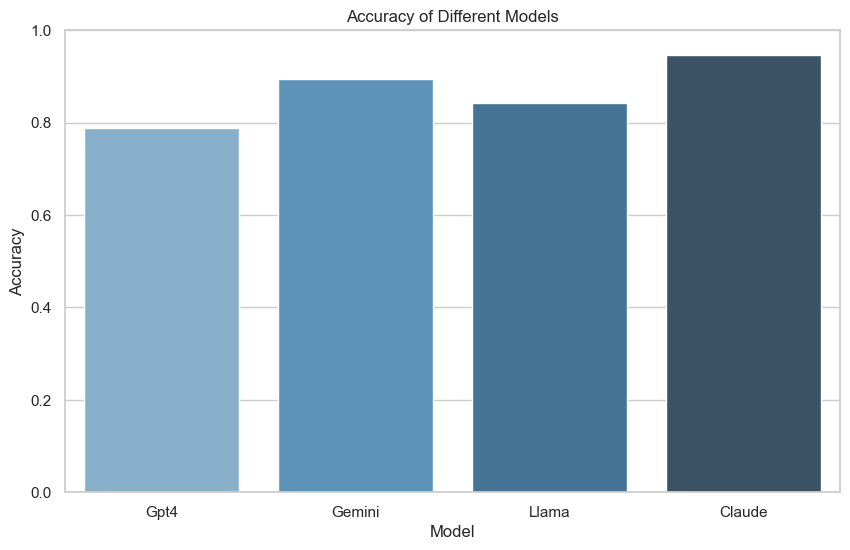

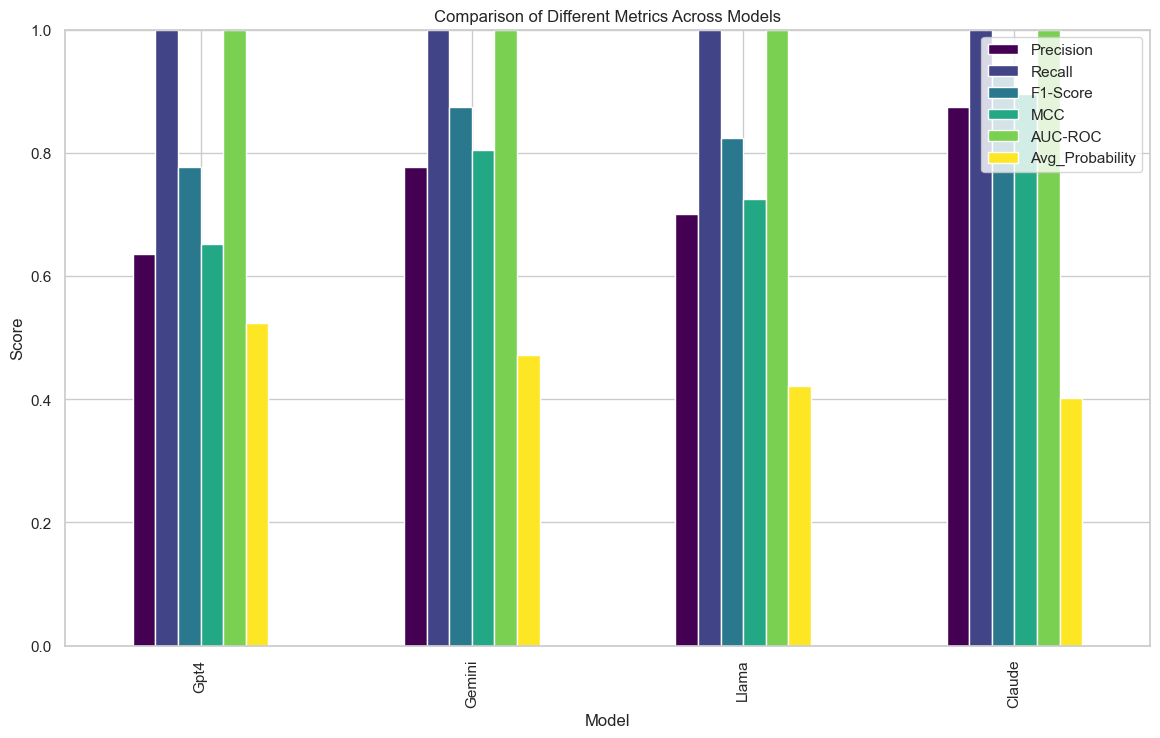

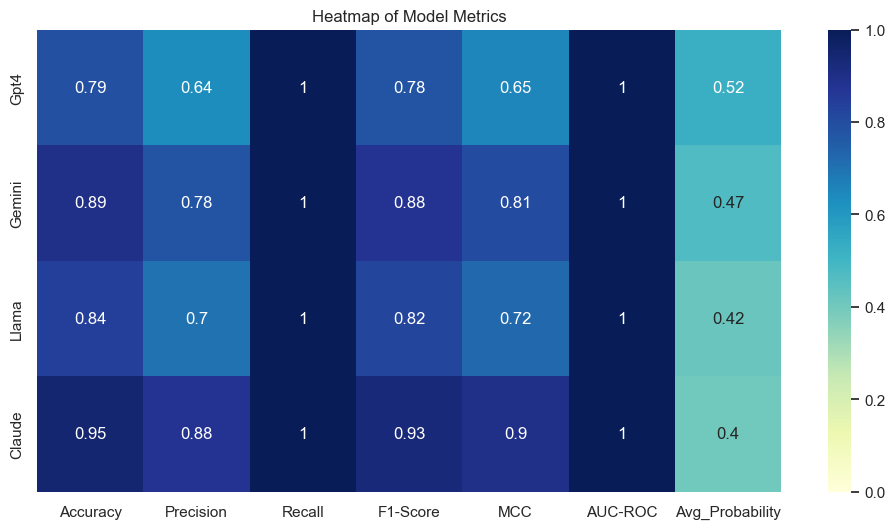

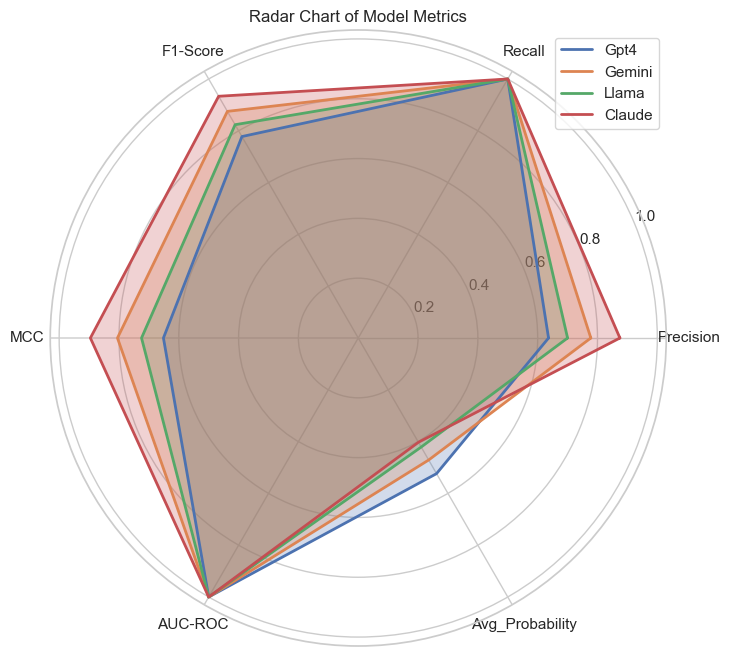

In [101]:
plot_model_metrics(all_metrics)